# 빅데이터분석 13강 - clustering

- clustering 개념
- 실습, k 정하기 
- cluster 분석

## clustering 개념
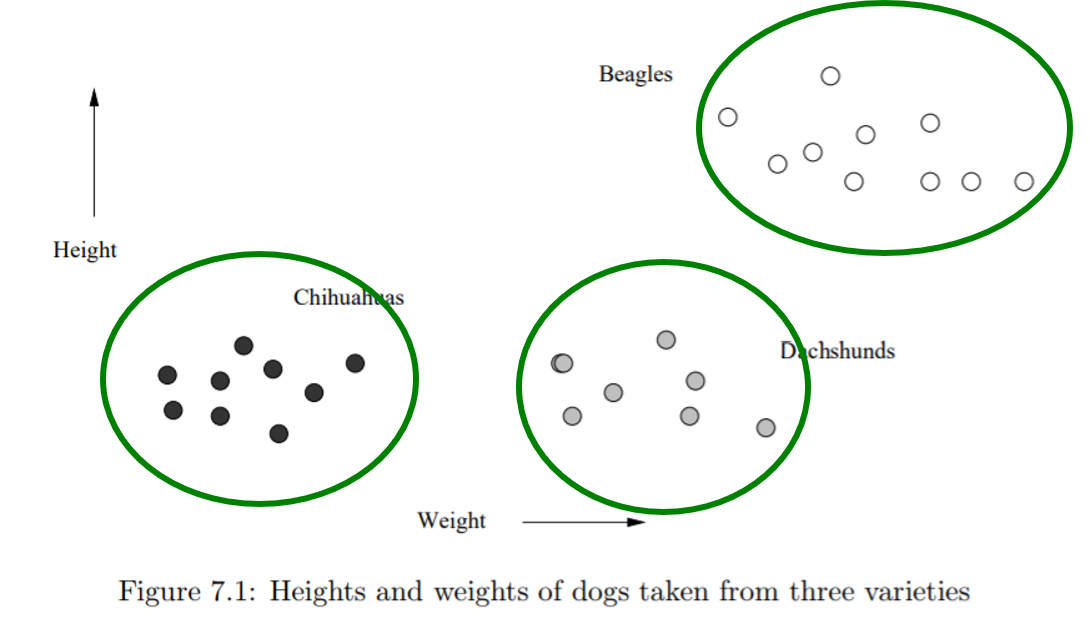

- 데이터 객체 들을 몇 개의 그룹으로 나누는 과정
    - 거리 : 특징 벡터 X 간 거리, euclidean 등
    - 같은 그룹 내의 객체 간 거리는 가깝게
    - 다른 그룹의 객체 간 거리는 멀게
- 데이터 분석 관점 : 어떤 그룹 들이 있는지
    - 몇 개가 정답인지는 모름
- 머신러닝 관점-비지도 학습 : 학습데이터에 y 값이 없음
    - 원래 분류가 안되는 데이터 vs. y값만 없는 경우 
    - clustering 완료 후에는 test data를 특정 cluster로 분류

### 1) 데이터 획득

In [3]:
import pandas as pd
import math

In [4]:
retail_df = pd.read_excel('Online_Retail.xlsx')
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


### 2) 데이터 준비 및 탐색

In [5]:
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


- 데이터 정련

In [6]:
# 오류 데이터 정제
retail_df = retail_df[retail_df['Quantity'] > 0] 
retail_df = retail_df[retail_df['UnitPrice'] > 0] 
retail_df = retail_df[retail_df['CustomerID'].notnull()] 

# 'CustomerID' 자료형을 str 으로 변환
retail_df['CustomerID'] = retail_df['CustomerID'].astype(int)
retail_df['CustomerID'] = retail_df['CustomerID'].astype(str)

In [7]:
retail_df.info()
print(retail_df.isnull().sum())
print(retail_df.shape)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 397884 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    397884 non-null  object        
 1   StockCode    397884 non-null  object        
 2   Description  397884 non-null  object        
 3   Quantity     397884 non-null  int64         
 4   InvoiceDate  397884 non-null  datetime64[ns]
 5   UnitPrice    397884 non-null  float64       
 6   CustomerID   397884 non-null  object        
 7   Country      397884 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 27.3+ MB
InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64
(397884, 8)


In [8]:
# 중복 레코드 제거 : 시간까지 같으면 중복
retail_df.drop_duplicates(inplace=True)

print(retail_df.shape) #작업 확인용 출력

(392692, 8)


- 제품 수, 거래건 수, 고객 수 탐색

In [7]:
print ("제품 수", len (retail_df['StockCode'].unique()))
print ("거래건 수", len (retail_df['InvoiceNo'].unique()))
print ("고객 수", len (retail_df['CustomerID'].unique()))

제품 수 3665
거래건 수 18532
고객 수 4338


- 국가별 count

In [8]:
retail_df['Country'].value_counts()

United Kingdom          349203
Germany                   9025
France                    8326
EIRE                      7226
Spain                     2479
Netherlands               2359
Belgium                   2031
Switzerland               1841
Portugal                  1453
Australia                 1181
Norway                    1071
Italy                      758
Channel Islands            747
Finland                    685
Cyprus                     603
Sweden                     450
Austria                    398
Denmark                    380
Poland                     330
Japan                      321
Israel                     245
Unspecified                241
Singapore                  222
Iceland                    182
USA                        179
Canada                     151
Greece                     145
Malta                      112
United Arab Emirates        68
European Community          60
RSA                         57
Lebanon                     45
Lithuani

In [9]:
# 금액 컬럼 추가 ; 단가 * 수량 = 금액
retail_df['SaleAmount'] = retail_df['UnitPrice'] * retail_df['Quantity']

retail_df.head() #작업 확인용 출력

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,SaleAmount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34


- 고객 별 통계 구하기 (거래 건수, 총액, 최종거래일)
- agg( 집계할 변수 dict ) 함수 : groupby ( ) 와 함께 사용
    - 집계할 변수 dict :  {변수명:집계함수}

In [10]:
aggregations = {    
    'InvoiceNo':'count',
    'SaleAmount':'sum',
    'InvoiceDate':'max'
}

customer_df = retail_df.groupby('CustomerID').agg(aggregations)
customer_df = customer_df.reset_index() # 하지 않으면 customrID가 index가 되어버림

customer_df.head()  #작업 확인용 출력

,CustomerID,InvoiceNo,SaleAmount,InvoiceDate
0,12346,1,77183.60,2011-01-18 10:01:00
1,12347,182,4310.00,2011-12-07 15:52:00
2,12348,31,1797.24,2011-09-25 13:13:00
3,12349,73,1757.55,2011-11-21 09:51:00
4,12350,17,334.40,2011-02-02 16:01:00


In [11]:
# 집계 결과 컬럼이름 바꾸기
customer_df = customer_df.rename(columns = {'InvoiceNo':'Freq', 'InvoiceDate':'LastTransaction'})

customer_df.head() #작업 확인용 출력

,CustomerID,Freq,SaleAmount,LastTransaction
0,12346,1,77183.60,2011-01-18 10:01:00
1,12347,182,4310.00,2011-12-07 15:52:00
2,12348,31,1797.24,2011-09-25 13:13:00
3,12349,73,1757.55,2011-11-21 09:51:00
4,12350,17,334.40,2011-02-02 16:01:00


 - 마지막 구매후 경과일 계산하기

In [17]:
import datetime 

customer_df['ElapsedDays'] = datetime.datetime(2011,12,11) - customer_df['LastTransaction']

customer_df.head() #작업 확인용 출력

,CustomerID,Freq,SaleAmount,LastTransaction,ElapsedDays
0,12346,1,77183.60,2011-01-18 10:01:00,326 days 13:59:00
1,12347,182,4310.00,2011-12-07 15:52:00,3 days 08:08:00
2,12348,31,1797.24,2011-09-25 13:13:00,76 days 10:47:00
3,12349,73,1757.55,2011-11-21 09:51:00,19 days 14:09:00
4,12350,17,334.40,2011-02-02 16:01:00,311 days 07:59:00


In [18]:
customer_df['ElapsedDays'] = customer_df['ElapsedDays'].apply(lambda x: x.days+1)
customer_df.head() #작업 확인용 출력

,CustomerID,Freq,SaleAmount,LastTransaction,ElapsedDays
0,12346,1,77183.60,2011-01-18 10:01:00,327
1,12347,182,4310.00,2011-12-07 15:52:00,4
2,12348,31,1797.24,2011-09-25 13:13:00,77
3,12349,73,1757.55,2011-11-21 09:51:00,20
4,12350,17,334.40,2011-02-02 16:01:00,312


- 데이터 값의 분포 시각화

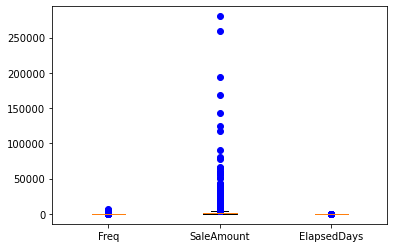

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots()
ax.boxplot([customer_df['Freq'], customer_df['SaleAmount'],customer_df['ElapsedDays']], sym='bo')
plt.xticks([1, 2, 3], ['Freq', 'SaleAmount', 'ElapsedDays'])
plt.show()

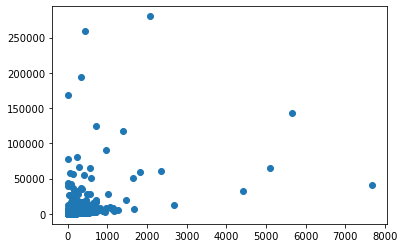

In [15]:
plt.scatter(customer_df['Freq'], customer_df['SaleAmount'] )

- 데이터 값의 분포폭이 너무 크다 
    - log scale로 변경

In [22]:
import numpy as np

customer_df['Freq_log'] = np.log1p(customer_df['Freq'])
customer_df['SaleAmount_log'] = np.log1p(customer_df['SaleAmount'])
customer_df['ElapsedDays_log'] = np.log1p(customer_df['ElapsedDays'])

customer_df.head()  #작업 확인용 출력

,CustomerID,Freq,SaleAmount,LastTransaction,ElapsedDays,Freq_log,SaleAmount_log,ElapsedDays_log
0,12346,1,77183.60,2011-01-18 10:01:00,327,0.693147,11.253955,5.793014
1,12347,182,4310.00,2011-12-07 15:52:00,4,5.209486,8.368925,1.609438
2,12348,31,1797.24,2011-09-25 13:13:00,77,3.465736,7.494564,4.356709
3,12349,73,1757.55,2011-11-21 09:51:00,20,4.304065,7.472245,3.044522
4,12350,17,334.40,2011-02-02 16:01:00,312,2.890372,5.815324,5.746203


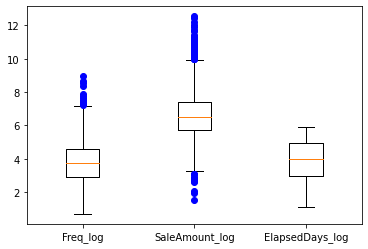

In [23]:
# 조정된 데이터 분포를 다시 박스플롯으로 확인하기
fig, ax = plt.subplots()
ax.boxplot([customer_df['Freq_log'], customer_df['SaleAmount_log'],customer_df['ElapsedDays_log']], sym='bo')
plt.xticks([1, 2, 3], ['Freq_log', 'SaleAmount_log', 'ElapsedDays_log'])
plt.show()

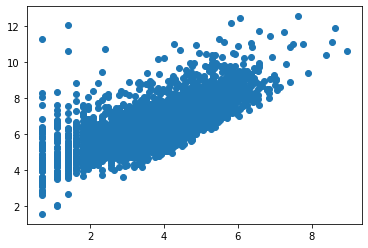

In [18]:
plt.scatter(customer_df['Freq_log'], customer_df['SaleAmount_log'] )

### 3)  K-means clustering


- 입력값
    - k: 클러스터 수
    - D: n 개의 데이터 오브젝트를 포함하는 집합
- 출력값: k 개의 클러스터

- 알고리즘

1. 데이터 오브젝트 집합 D에서 k 개의 데이터 오브젝트를 임의로 추출하고, 이 데이터 오브젝트들을 각 클러스터의 중심 (centroid) 으로 설정한다. (초기값 설정)

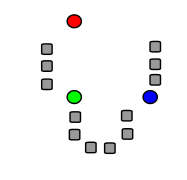

2. 집합 D의 각 데이터 오브젝트들에 대해 k 개의 클러스터 중심 오브젝트와의 거리를 각각 구하고, 각 데이터 오브젝트가 어느 중심점 (centroid) 와 가장 유사도가 높은지 알아낸다. 그리고 그렇게 찾아낸 중심점으로 각 데이터 오브젝트들을 할당한다.

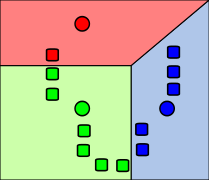

3. 클러스터의 중심점을 다시 계산한다. 즉, 2에서 재할당된 클러스터들을 기준으로 중심점을 다시 계산한다.

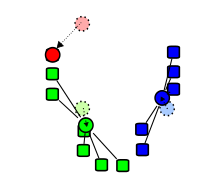
4. 각 데이터 오브젝트의 소속 클러스터가 바뀌지 않을 때까지 2, 3 과정을 반복한다.

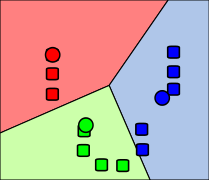

In [14]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

In [24]:
X_features = customer_df[['Freq_log', 'SaleAmount_log', 'ElapsedDays_log']].values

In [25]:
# 정규 분포로 다시 스케일링하기
from sklearn.preprocessing import StandardScaler

X_features_scaled = StandardScaler().fit_transform(X_features)

### - 최적의 k 찾기 
- k 값에 따라 clustering의 성능이 좌우됨

- 엘보우 방법 : 클러스터의 수를 순차적으로 늘려가면서 결과를 모니터링 한다. 만약 하나의 클러스터를 추가했을 때 이전보다 훨씬 더 나은 결과를 나타내지 않는다면, 이전의 클러스터의 수를 선택

- 평가지표 : 내부 평가 vs. 외부 평가
    - 내부평가 : 클러스터링한 결과 그 자체를 놓고 평가하는 방식 
    - 외부평가 : 정답지와 대조

- 내부평가 
    - 클러스터 내 높은 유사도 (high intra-cluster similarity) :  inertia
    - 클러스터 간 낮은 유사도 (low inter-cluster similarity) 
    - 실루엣 : 각 개체 별로 (외부 cluster 멤버와의 거리 -  내부 cluster 멤버와의 거리)/ 최대거리  
    


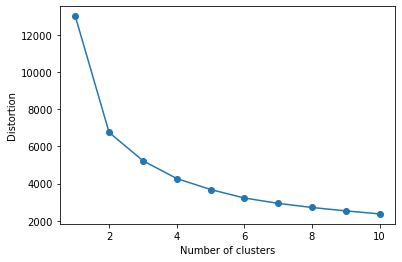

In [26]:
distortions = []

for i in range(1, 11):
    kmeans_i = KMeans(n_clusters=i, random_state=0)  # 모델 생성
    kmeans_i.fit(X_features_scaled)   # 모델 훈련
    distortions.append(kmeans_i.inertia_) #  클러스터 내 센트로이드와의 거리 제곱합
    
plt.plot(range(1,11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

In [27]:
kmeans = KMeans(n_clusters=3, random_state=0) # 모델 생성

# 모델 학습과 결과 예측(클러스터 레이블 생성)
Y_labels = kmeans.fit_predict(X_features_scaled) 
print (Y_labels)

[2 1 2 ... 2 1 2]


In [28]:
customer_df['ClusterLabel'] = Y_labels

customer_df.head()  #작업 확인용 출력

,CustomerID,Freq,SaleAmount,LastTransaction,ElapsedDays,Freq_log,SaleAmount_log,ElapsedDays_log,ClusterLabel
0,12346,1,77183.60,2011-01-18 10:01:00,327,0.693147,11.253955,5.793014,2
1,12347,182,4310.00,2011-12-07 15:52:00,4,5.209486,8.368925,1.609438,1
2,12348,31,1797.24,2011-09-25 13:13:00,77,3.465736,7.494564,4.356709,2
3,12349,73,1757.55,2011-11-21 09:51:00,20,4.304065,7.472245,3.044522,2
4,12350,17,334.40,2011-02-02 16:01:00,312,2.890372,5.815324,5.746203,0


## 4) 시각화

- 실루엣 계수를 시각화

In [29]:
silhouette_values = silhouette_samples(X_features, Y_labels, metric='euclidean')
print (silhouette_values )

[0.03362327 0.50775226 0.37864942 ... 0.05995421 0.42980636 0.26891638]


- jet (숫자) : color map

In [31]:
from matplotlib import cm

def silhouetteViz(n_cluster, X_features): 
    
    kmeans = KMeans(n_clusters=n_cluster, random_state=0)
    Y_labels = kmeans.fit_predict(X_features)
    
    silhouette_values = silhouette_samples(X_features, Y_labels, metric='euclidean')

    y_ax_lower, y_ax_upper = 0, 0
    y_ticks = []

    for c in range(n_cluster):
        c_silhouettes = silhouette_values[Y_labels == c]
        c_silhouettes.sort()
        y_ax_upper += len(c_silhouettes)
        color = cm.jet(float(c) / n_cluster)
        plt.barh(range(y_ax_lower, y_ax_upper), c_silhouettes,
                 height=1.0, edgecolor='none', color=color)
        y_ticks.append((y_ax_lower + y_ax_upper) / 2.)
        y_ax_lower += len(c_silhouettes)
    
    silhouette_avg = np.mean(silhouette_values)
    plt.axvline(silhouette_avg, color='red', linestyle='--')
    plt.title('Number of Cluster : '+ str(n_cluster)+'\n' \
              + 'Silhouette Score : '+ str(round(silhouette_avg,3)))
    plt.yticks(y_ticks, range(n_cluster))   
    plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.ylabel('Cluster')
    plt.xlabel('Silhouette coefficient')
    plt.tight_layout()
    plt.show()

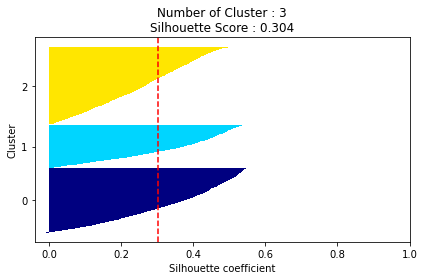

In [32]:
silhouetteViz(3, X_features_scaled) #클러스터 3개인 경우의 실루엣 score 및 각 클러스터 비중 시각화

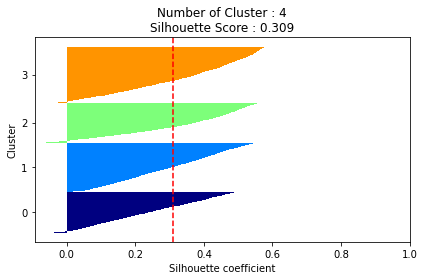

In [33]:
silhouetteViz(4, X_features_scaled) #클러스터 4개인 경우의 실루엣 score 및 각 클러스터 비중 시각화

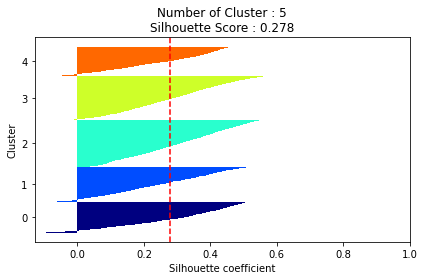

In [34]:
silhouetteViz(5, X_features_scaled) #클러스터 5개인 경우의 실루엣 score 및 각 클러스터 비중 시각화

In [ ]:
silhouetteViz(6, X_features_scaled) #클러스터 6개인 경우의 실루엣 score 및 각 클러스터 비중 시각화

- 클러스터 데이터 분포의 시각화 


In [36]:
def clusterScatter(n_cluster, X_features): 
    c_colors = []
    kmeans = KMeans(n_clusters=n_cluster, random_state=0)
    Y_labels = kmeans.fit_predict(X_features)

    for i in range(n_cluster):
        c_color = cm.jet(float(i) / n_cluster) #클러스터의 색상 설정
        c_colors.append(c_color)
        #클러스터의 데이터 분포를 동그라미로 시각화
        plt.scatter(X_features[Y_labels == i,0], X_features[Y_labels == i,1],
                     marker='o', color=c_color, edgecolor='black', s=50, 
                     label='cluster '+ str(i))       
    
    #각 클러스터의 중심점을 삼각형으로 표시

    for i in range(n_cluster):
        plt.scatter(kmeans.cluster_centers_[i,0], kmeans.cluster_centers_[i,1], 
                    marker='^', color=c_colors[i], edgecolor='w', s=200)
        
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

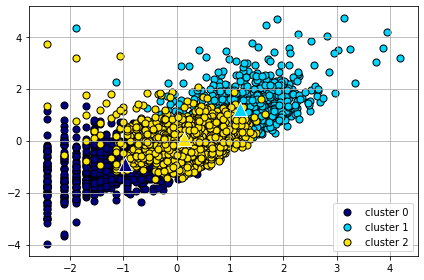

In [37]:
clusterScatter(3, X_features_scaled) #클러스터 3개인 경우의 클러스터 데이터 분포 시각화

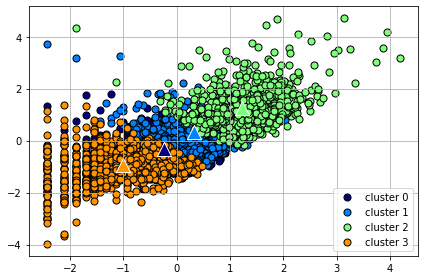

In [38]:
clusterScatter(4, X_features_scaled)  #클러스터 4개인 경우의 클러스터 데이터 분포 시각화

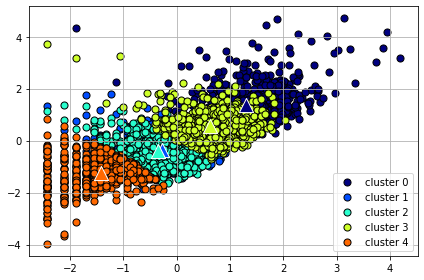

In [39]:
clusterScatter(5, X_features_scaled)  #클러스터 5개인 경우의 클러스터 데이터 분포 시각화

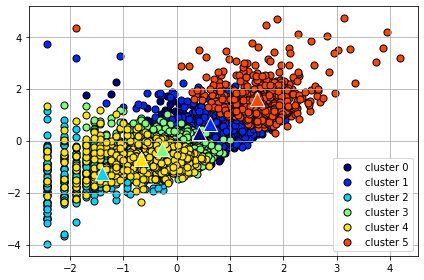

In [40]:
clusterScatter(6, X_features_scaled)  #클러스터 6개인 경우의 클러스터 데이터 분포 시각화

- 결정된 k를 적용하여 최적의 K-mans 모델 완성

In [41]:
best_cluster = 4

kmeans = KMeans(n_clusters=best_cluster, random_state=0)
Y_labels = kmeans.fit_predict(X_features_scaled)

In [42]:
customer_df['ClusterLabel'] = Y_labels

customer_df.head()   #작업 확인용 출력

,CustomerID,Freq,SaleAmount,LastTransaction,ElapsedDays,Freq_log,SaleAmount_log,ElapsedDays_log,ClusterLabel
0,12346,1,77183.60,2011-01-18 10:01:00,327,0.693147,11.253955,5.793014,1
1,12347,182,4310.00,2011-12-07 15:52:00,4,5.209486,8.368925,1.609438,2
2,12348,31,1797.24,2011-09-25 13:13:00,77,3.465736,7.494564,4.356709,1
3,12349,73,1757.55,2011-11-21 09:51:00,20,4.304065,7.472245,3.044522,2
4,12350,17,334.40,2011-02-02 16:01:00,312,2.890372,5.815324,5.746203,3


- ClusterLabel이 추가된 데이터를 파일로 저장

In [43]:
customer_df.to_csv('Online_Retail_Customer_Cluster.csv')

## 클러스터 분석하기

### 1) 각 클러스터의 고객수 

In [44]:
customer_df.groupby('ClusterLabel')['CustomerID'].count()

ClusterLabel
0     952
1    1148
2     932
3    1306
Name: CustomerID, dtype: int64

### 2) 각 클러스터의 특징

In [45]:
customer_cluster_df = customer_df.drop(['Freq_log', 'SaleAmount_log', 'ElapsedDays_log'],axis=1, inplace=False)

In [46]:
# 주문 1회당 평균 구매금액 : SaleAmountAvg
customer_cluster_df['SaleAmountAvg'] = customer_cluster_df['SaleAmount']/customer_cluster_df['Freq']

customer_cluster_df.head()

,CustomerID,Freq,SaleAmount,LastTransaction,ElapsedDays,ClusterLabel,SaleAmountAvg
0,12346,1,77183.60,2011-01-18 10:01:00,327,1,77183.600000
1,12347,182,4310.00,2011-12-07 15:52:00,4,2,23.681319
2,12348,31,1797.24,2011-09-25 13:13:00,77,1,57.975484
3,12349,73,1757.55,2011-11-21 09:51:00,20,2,24.076027
4,12350,17,334.40,2011-02-02 16:01:00,312,3,19.670588


In [47]:
# 클러스터별 분석
customer_cluster_df.drop(['CustomerID'],axis=1, inplace=False).groupby('ClusterLabel').mean()

,Freq,SaleAmount,ElapsedDays,SaleAmountAvg
ClusterLabel,,,,
0,38.631303,601.927417,23.034664,31.252920
1,75.160279,1461.008146,105.372822,107.970710
2,268.937768,6716.946888,15.860515,91.855201
3,14.533691,288.470246,191.692956,43.895201
